## Import libs

In [1]:
import numpy as np
import torch
import gpytorch
from matplotlib import pyplot as plt 
from sklearn.model_selection import train_test_split 
import os 
import pandas as pd

# Set up GPU usage 
useGPU = True
if useGPU == True: # 6 is for personal use 
    os.environ["CUDA_VISIBLE_DEVICES"] = "5, 6"
    output_device = torch.device('cuda:0')
    n_devices = torch.cuda.device_count()
    output_device = torch.device('cuda:0')
    print('Planning to run on {} GPUs'.format(n_devices))
    
elif useGPU == False: 
    os.environ["CUDA_VISIBLE_DEVICES"] = ""
    output_device = torch.device('cpu')
    print('Using CPU')
else: 
    raise ValueError("Incorrect value of useGPU variable")

Planning to run on 2 GPUs


## Utilities

In [2]:
def save_checkpoint(model, optimizer, history, iters, fileName):
    torch.save({'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'history': history,
                'iterations': iters
                },
            fileName)
    
# Diagnostics 
def alpha_vs_Mach(x_af, y_pred_af, y_true_af, titleStr='MAE: ' + r'$\alpha$' + ' vs. M'):
    x_af = x_af.cpu().detach().numpy()
    x_af[:, -3] = np.round(np.rad2deg(x_af[:, -3]), 2)
    y_pred_af = y_pred_af.cpu().detach().numpy()/100
    y_true_af = y_true_af.cpu().detach().numpy()/100
    
    M_list = np.unique(x_af[:, -2])
    A_list = np.unique(x_af[:, -3])
    MAE_arr = np.empty((M_list.shape[0], A_list.shape[0]))
    MAE_arr[:] = np.nan

    for i in range(0, M_list.shape[0]):
        for j in range(0, A_list.shape[0]):
            ind1 = np.argwhere(x_af[:, -2]==M_list[i])
            ind2 = np.argwhere(x_af[:, -3]==A_list[j])
            search_ind = np.intersect1d(ind1, ind2)
            
            # Grab all Cp along x/c and obtain average MAE
            MAE_arr[-1-i, j] = np.mean(np.abs(y_pred_af[search_ind] - y_true_af[search_ind]))
    
    # Create plot 
    f = plt.figure()
    ax = f.gca()
    im = ax.imshow(MAE_arr, cmap='Oranges')
    ax.set_yticks(np.arange(0, M_list.shape[0]), np.flip(M_list))
    ax.set_xticks(np.arange(0, A_list.shape[0]), A_list)
    f.colorbar(im, label='MAE')
    ax.title.set_text(titleStr)
    ax.set_xlabel('Angle of attack, ' + r'$\alpha$ [deg]')
    ax.set_ylabel('Mach Number, M')
    ax.set_aspect('auto')
    return MAE_arr, (f, ax)

def xc_vs_airfoil(x_af, y_pred_af, y_true_af, titleStr='MAE: ' + r'$\alpha$' + ' vs. M'):
    x_af = x_af.cpu().detach().numpy()
    x_af[:, -3] = np.round(np.rad2deg(x_af[:, -3]), 2)
    sort_ind = np.lexsort((x_af[:,-3], x_af[:,-2]))
    x_af = x_af[sort_ind]
    y_pred_af = y_pred_af.cpu().detach().numpy()/100
    y_pred_af = y_pred_af[sort_ind]
    y_true_af = y_true_af.cpu().detach().numpy()/100
    y_true_af = y_true_af[sort_ind]
    
    xc_list = np.unique(x_af[:, -1])
    inds = np.where(np.abs(np.diff(x_af[:,-1])) > 1)[0]+1

    N = inds.shape[0]
    MAE_arr = np.empty((N, xc_list.shape[0]))
    MAE_arr[:] = np.nan
    
    prev_pt = 0
    tick_label = []
    for i in range(0, N):
        # Make tick label str 
        tick_label.append('M = ' + str(x_af[inds[i]-1, -2]) + r', $\alpha$ = ' + str(x_af[inds[i]-1, -3]))
        for j in range(prev_pt, inds[i]):
            new_ind = np.argwhere(xc_list == x_af[j, -1])
            MAE_arr[-1-i, new_ind] = np.abs(y_pred_af[j] - y_true_af[j])
        prev_pt = inds[i]
        
    f = plt.figure()
    ax = f.gca()
    im = ax.imshow(MAE_arr, cmap='Oranges')
    ax.set_aspect('auto')
    f.colorbar(im, label='MAE')
    ax.title.set_text(titleStr)
    ax.set_xlabel('Unraveled x/c')
    ax.set_ylabel('Case')
    ax.set_yticks(np.arange(0, N), np.flip(tick_label))
    ax.set_xticks(np.linspace(0, xc_list.shape[0]-1, 8), np.round(xc_list[np.linspace(0, xc_list.shape[0]-1, 8, dtype=int)], 2))
    return MAE_arr, (f, ax)

def data_breakdown(data_raw): # Redo this 
    infos = data_raw[['af', 'symmetry', 'supercritical', 'M' ,'alpha']]
    symm = infos[infos['symmetry'] == 'symmetric']
    camb = infos[infos['symmetry'] == 'cambered']
    symm_supercrit = symm[symm['supercritical']=='supercritical']
    symm_classic = symm[symm['supercritical'] != 'supercritical']
    camb_supercrit = camb[camb['supercritical']=='supercritical']
    camb_classic = camb[camb['supercritical'] != 'supercritical']
    result1 = np.array([[len(symm_classic), len(symm_supercrit)], 
                        [len(camb_classic), len(camb_supercrit)]])

    
    f1, ax1 = plt.subplots()
    im1 = ax1.imshow(result1, cmap='Blues')
    ax1.set_yticks([0, 1], labels=['Symmetric', 'Cambered'])
    ax1.set_xticks([0, 1], labels=['Classic', 'Supercritical'])
    for i in range(0, 2):
        for j in range(0, 2):
            text = ax1.text(j, i, result1[i, j],
                        ha="center", va="center", color="k")
    f1.colorbar(im1, ax=ax1)        
    ax1.title.set_text('Breakdown of available data'  + '\n Total: ' + str(np.sum(np.sum(result1))))
    plt.show()
    
    # Category vs. Number at varying M 
    M_range = np.arange(0.0+0.05, 1.0, 0.1)
    result2 = np.zeros((4, M_range.shape[0]))
    iter_list_x = [symm_classic, camb_classic, symm_supercrit, camb_supercrit]
    # iter_list_y1 = [symm_classic_true, camb_classic_true, symm_supercr_true, camb_supercr_true]
    for i in range(0, len(iter_list_x)):
        for j in range(0, M_range.shape[0]):
            new_ind = np.abs(iter_list_x[i]['M']-M_range[j]) < 0.05
            result2[i, j] = len(iter_list_x[i]['M'][new_ind])
    
    f2, ax2 = plt.subplots(figsize=(8,2))
    im2 = ax2.imshow(result2, cmap='Blues')
    ax2.set_yticks([0, 1, 2, 3], labels=['Symmetric, classic', 'Cambered, classic', 'Symmetric, supercritical', 'Cambered, supercritical'])
    ax2.set_xticks(np.arange(0, M_range.shape[0]), labels=np.round(M_range-0.05, 2))
    for i in range(0, 4):
        for j in range(0, M_range.shape[0]):
            text = ax2.text(j, i, int(result2[i, j]) if not np.isnan(result2[i,j]) else '',
                        ha="center", va="center", color="k")
    f2.colorbar(im2, ax=ax2, label='MAE')        
    ax2.title.set_text('Number of available training data vs. M' + '\n Total: ' + str(int(np.sum(np.sum(result2)))))
    ax2.set_xlabel('Mach number')
    ax2.set_aspect('auto')
    plt.show()
    
    # Category vs. Number at varying alpha 
    A_range = np.arange(-16.0, 31.0, 1.0)
    result3 = np.zeros((4, A_range.shape[0]))
    iter_list_x = [symm_classic, camb_classic, symm_supercrit, camb_supercrit]
    for i in range(0, len(iter_list_x)):
        for j in range(0, A_range.shape[0]):
            new_ind = (iter_list_x[i]['alpha']-A_range[j] < 0.5) & (iter_list_x[i]['alpha']-A_range[j] >= -0.5)
            result3[i, j] = len(iter_list_x[i]['alpha'][new_ind])
            
    f3, ax3 = plt.subplots(figsize=(27,2))
    im3 = ax3.imshow(result3, cmap='Blues')
    ax3.set_yticks([0, 1, 2, 3], labels=['Symmetric, classic', 'Cambered, classic', 'Symmetric, supercritical', 'Cambered, supercritical'])
    ax3.set_xticks(np.arange(0, A_range.shape[0]), labels=np.round(A_range, 2))
    for i in range(0, 4):
        for j in range(0, A_range.shape[0]):
            text = ax3.text(j, i, int(result3[i, j]) if not np.isnan(result3[i,j]) else '',
                        ha="center", va="center", color="k")
    f3.colorbar(im3, ax=ax3, label='MAE')        
    ax3.title.set_text('Number of available training data vs. ' + r'$\alpha$' + '\n Total: ' + str(int(np.sum(np.sum(result3)))))
    ax3.set_aspect('auto')
    ax3.set_xlabel('Angle of attack [deg] ')
    plt.show()
    
    # By airfoil 
    f4, ax4 = plt.subplots()
    result4 = np.array([[len(pd.unique(symm_classic['af'])), len(pd.unique(symm_supercrit['af']))], 
                        [len(pd.unique(camb_classic['af'])), len(pd.unique(camb_supercrit['af']))]])
    im4 = ax4.imshow(result4, cmap='Blues')
    ax4.set_yticks([0, 1], labels=['Symmetric', 'Cambered'])
    ax4.set_xticks([0, 1], labels=['Classic', 'Supercritical'])
    for i in range(0, 2):
        for j in range(0, 2):
            text = ax4.text(j, i, result4[i, j],
                        ha="center", va="center", color="k")
    f4.colorbar(im4, ax=ax4)        
    ax4.title.set_text('Breakdown of available data'  + '\n Total airfoils: ' + str(np.sum(np.sum(result4))))
    plt.show()
    
    return (f1, ax1), (f2, ax2), (f3, ax3), (f4, ax4)

def accuracy_breakdown(model, train_y, train_x, train_category):
    # Category vs. MAE
    with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
        preds_model = model(train_x)
    preds = preds_model.mean.cpu().detach().numpy()
    train_y = train_y.cpu().detach().numpy()
    train_x = train_x.cpu().detach().numpy()
        # Create array 
    symm = preds[train_category['symmetry']=='symmetric']
    symm_true = train_y[train_category['symmetry']=='symmetric']
    symm_cat = train_category[train_category['symmetry']=='symmetric']
    symm_x = train_x[train_category['symmetry']=='symmetric']
    
    camb = preds[train_category['symmetry']=='cambered']
    camb_true = train_y[train_category['symmetry']=='cambered']
    camb_cat = train_category[train_category['symmetry']=='cambered']
    camb_x = train_x[train_category['symmetry']=='cambered']
    
    symm_supercr = symm[symm_cat['supercritical']=='supercritical']
    symm_supercr_true = symm_true[symm_cat['supercritical']=='supercritical']
    symm_classic = symm[symm_cat['supercritical']!='supercritical']
    symm_classic_true = symm_true[symm_cat['supercritical']!='supercritical']
    symm_supercr_x = symm_x[symm_cat['supercritical']=='supercritical']
    symm_classic_x = symm_x[symm_cat['supercritical']!='supercritical']
    
    camb_supercr = camb[camb_cat['supercritical']=='supercritical']
    camb_supercr_true = camb_true[camb_cat['supercritical']=='supercritical']
    camb_classic = camb[camb_cat['supercritical']!='supercritical']
    camb_classic_true = camb_true[camb_cat['supercritical']!='supercritical']
    camb_supercr_x = camb_x[camb_cat['supercritical']=='supercritical']
    camb_classic_x = camb_x[camb_cat['supercritical']!='supercritical']
    
    result1 = np.array([[np.mean(np.abs(symm_classic - symm_classic_true)), np.mean(np.abs(symm_supercr - symm_supercr_true))],
                        [np.mean(np.abs(camb_classic - camb_classic_true)), np.mean(np.abs(camb_supercr - camb_supercr_true))]])
    
    f1, ax1 = plt.subplots()
    im1 = ax1.imshow(result1, cmap='Reds')
    ax1.set_yticks([0, 1], labels=['Symmetric', 'Cambered'])
    ax1.set_xticks([0, 1], labels=['Classic', 'Supercritical'])
    for i in range(0, 2):
        for j in range(0, 2):
            text = ax1.text(j, i, result1[i, j] if not np.isnan(result1[i,j]) else '',
                        ha="center", va="center", color="k")
    f1.colorbar(im1, ax=ax1, label='MAE [100 $C_p$]')        
    ax1.title.set_text('MAE of predictions on data')
    plt.show()
    
    # Category vs. MAE at varying M 
    M_range = np.arange(0.0+0.05, 1.0, 0.1)
    result2 = np.zeros((4, M_range.shape[0]))
    iter_list_x = [symm_classic_x, camb_classic_x, symm_supercr_x, camb_supercr_x]
    iter_list_y1 = [symm_classic_true, camb_classic_true, symm_supercr_true, camb_supercr_true]
    iter_list_y2 = [symm_classic, camb_classic, symm_supercr, camb_supercr]
    for i in range(0, len(iter_list_x)):
        for j in range(0, M_range.shape[0]):
            new_ind = (iter_list_x[i][:,-2]-M_range[j] < 0.05) & (iter_list_x[i][:,-2]-M_range[j] >= -0.05)#np.abs(iter_list_x[i][:,-2]-M_range[j]) <= 0.05
            result2[i, j] = np.mean(np.abs(iter_list_y1[i][new_ind] - iter_list_y2[i][new_ind]))
            
    f2, ax2 = plt.subplots(figsize=(8,2))
    im2 = ax2.imshow(result2, cmap='Reds')
    ax2.set_yticks([0, 1, 2, 3], labels=['Symmetric, classic', 'Cambered, classic', 'Symmetric, supercritical', 'Cambered, supercritical'])
    ax2.set_xticks(np.arange(0, M_range.shape[0]), labels=np.round(M_range-0.05, 2))
    for i in range(0, 4):
        for j in range(0, M_range.shape[0]):
            text = ax2.text(j, i, np.round(result2[i, j], 2) if not np.isnan(result2[i,j]) else '',
                        ha="center", va="center", color="k")
    f2.colorbar(im2, ax=ax2, label='MAE [100 $C_p$]')        
    ax2.title.set_text('MAE of predictions on data vs. M')
    ax2.set_xlabel('Mach number')
    ax2.set_aspect('auto')
    plt.show()
    
    # Category vs. MAE at varying alpha 
    A_range = np.arange(-16.0, 31.0, 1.0)
    result3 = np.zeros((4, A_range.shape[0]))
    iter_list_x = [symm_classic_x, camb_classic_x, symm_supercr_x, camb_supercr_x]
    iter_list_y1 = [symm_classic_true, camb_classic_true, symm_supercr_true, camb_supercr_true]
    iter_list_y2 = [symm_classic, camb_classic, symm_supercr, camb_supercr]
    for i in range(0, len(iter_list_x)):
        for j in range(0, A_range.shape[0]):
            new_ind = (iter_list_x[i][:,-3]-A_range[j] < 0.5) & (iter_list_x[i][:,-3]-A_range[j] >= -0.5) #  np.abs(iter_list_x[i][:,-3]-A_range[j]) <= 0.5
            result3[i, j] = np.mean(np.abs(iter_list_y1[i][new_ind] - iter_list_y2[i][new_ind]))
            
    f3, ax3 = plt.subplots(figsize=(27,2))
    im3 = ax3.imshow(result3, cmap='Reds')
    ax3.set_yticks([0, 1, 2, 3], labels=['Symmetric, classic', 'Cambered, classic', 'Symmetric, supercritical', 'Cambered, supercritical'])
    ax3.set_xticks(np.arange(0, A_range.shape[0]), labels=np.round(A_range, 2))
    for i in range(0, 4):
        for j in range(0, A_range.shape[0]):
            text = ax3.text(j, i, np.round(result3[i, j], 2) if not np.isnan(result3[i,j]) else '',
                        ha="center", va="center", color="k")
    f3.colorbar(im3, ax=ax3, label='MAE [100 $C_p$]')        
    ax3.title.set_text('MAE of predictions on data vs. ' + r'$\alpha$')
    ax3.set_aspect('auto')
    ax3.set_xlabel('Angle of attack [deg] ')
    plt.show()
    
    return (f1, ax1),  (f2, ax2),  (f3, ax3)

## Import data and pre-process

In [3]:
# Useful variables 
random_test = False
y_scale = 10

# Read data 
data_raw = pd.read_csv('./expData_20240422_added.csv') # Read csv 
num_xc = 26*2 # Number of points in x/c, upper and lower
data_index = data_raw.columns[num_xc:num_xc+num_xc].append(data_raw.columns[[2*num_xc, 2*num_xc+2, 2*num_xc+1]])#data_raw.columns[52:52+52].append(data_raw.columns[[104, 106, 105]]) # Choose columns for training data 
af = data_raw['af']
cat = data_raw[['symmetry', 'supercritical']]

X = torch.Tensor(np.array(data_raw[data_index]))
X[:, -3] = torch.deg2rad(X[:, -3])
# x_mean_scaler = torch.mean(X, axis=0)
# x_std_scaler = torch.std(X, axis=0)
# X[:, :-3] = (X[:, :-3] - x_mean_scaler[:-3])/x_std_scaler[:-3]
noise = (torch.Tensor(data_raw['noise'])*y_scale)**2 
# del x_mean_scaler, x_std_scaler

# Train - test split for airfoils 
af_unique = np.unique(af)
if random_test: 
    # Randomly select test set 
    train_afu, test_afu = train_test_split(af_unique, test_size = .1, random_state = 1) 
elif random_test == False:
    # Manual override of the test set 
    test_afu = ['NACA64A406', 'SC1095','NACA64A010', 'NACA64A410']

train_afu = np.delete(af_unique, np.argwhere(af_unique==test_afu[0]))
for i in range(1, len(test_afu)):
    train_afu = np.delete(train_afu, np.argwhere(train_afu==test_afu[i])) 

train_ind = data_raw['af'].isin(train_afu).values
test_ind = data_raw['af'].isin(test_afu).values

# process y 
y = torch.Tensor(data_raw['Cp'])*y_scale # Scale up for numerical stability 
y_mean = torch.mean(y)
y -= y_mean
# y_std = torch.std(y)

# train - test split 
train_x, test_x, train_y, test_y, train_af, test_af = X[train_ind], X[test_ind], y[train_ind], y[test_ind], data_raw['af'][train_ind], data_raw['af'][test_ind]
# mean_x = torch.mean(train_x, axis = 0)
# std_x = torch.max(torch.abs(train_x), axis = 0)[0]

train_noise, test_noise, train_cat, test_cat = noise[train_ind], noise[test_ind], cat[train_ind], cat[test_ind]
train_x, train_y  = train_x.to(output_device), train_y.to(output_device)
print(train_x.shape)
# test_x, test_y = test_x.to(output_device), test_y.to(output_device)

/tmp/ipykernel_3395648/3770433214.py:6: DtypeWarning: Columns (110) have mixed types. Specify dtype option on import or set low_memory=False.
  data_raw = pd.read_csv('./expData_20240422_added.csv') # Read csv


torch.Size([28390, 55])


### GP Regression model 

In [5]:
data_dim = train_x.size(-1)
nn_dims = [1000, 500, 300, 8] 
import math
from gpytorch.priors import NormalPrior
from gpytorch.constraints import Positive, GreaterThan

class LargeFeatureExtractor(torch.nn.Sequential):
    def __init__(self):
        super(LargeFeatureExtractor, self).__init__()
        self.add_module('linear1', torch.nn.Linear(data_dim, nn_dims[0]))
        self.add_module('relu1', torch.nn.ReLU())
        self.add_module('linear2', torch.nn.Linear(nn_dims[0], nn_dims[1]))
        self.add_module('relu2', torch.nn.ReLU())
        self.add_module('linear3', torch.nn.Linear(nn_dims[1], nn_dims[2]))
        self.add_module('relu3', torch.nn.ReLU())
        self.add_module('linear4', torch.nn.Linear(nn_dims[2], nn_dims[3]))
        if len(nn_dims) > 4:
            self.add_module('relu4', torch.nn.ReLU())
            self.add_module('linear5', torch.nn.Linear(nn_dims[3], nn_dims[4]))
            
from gpytorch.variational import CholeskyVariationalDistribution, DeltaVariationalDistribution
from gpytorch.variational import VariationalStrategy

np_ind = np.random.choice(np.arange(0, train_x.shape[0]), size = 1000)
# inducing_points = torch.Tensor(np.random.uniform(-1.0, 1.0, size=(800, num_xc+3)))
inducing_points = train_x[np_ind]

# class GPRegressionModel(gpytorch.models.ApproximateGP):
#         def __init__(self, inducing_points):
#             variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
#             variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True, jitter_val = 1e-4)
            
#             super().__init__(variational_strategy)
#             self.mean_module = gpytorch.means.ConstantMean()
#             self.covar_module = gpytorch.kernels.ScaleKernel(
#             gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=nn_dims[-1],
                
#             )
#             , outputscale_prior= NormalPrior(0.0, 10.0), outputscale_constraint=GreaterThan(1e-4) 
#             )
 
#             self.feature_extractor = LargeFeatureExtractor()

#             # This module will scale the NN features so that they're nice values
#             self.scale_to_bounds = gpytorch.utils.grid.ScaleToBounds(-1.0, 1.0)

#         def forward(self, x):
#             # We're first putting our data through a deep net (feature extractor)
#             projected_x = self.feature_extractor(x)
#             projected_x = self.scale_to_bounds(projected_x)  # Make the NN values "nice"

#             mean_x = self.mean_module(projected_x)
#             covar_x = self.covar_module(projected_x)
#             return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        
class multiGPU_ExactGP(gpytorch.models.ExactGP):
        def __init__(self, train_x, train_y, likelihood, n_devices):
            super(multiGPU_ExactGP, self).__init__(train_x, train_y, likelihood)
            # Mean Module
            self.mean_module = gpytorch.means.ConstantMean()
            
            # Covariance module 
            self.covar_module = gpytorch.kernels.ScaleKernel(
                gpytorch.kernels.keops.MaternKernel(nu=2.5, ard_num_dims=nn_dims[-1]),
                    outputscale_prior= NormalPrior(0.0, 10.0), outputscale_constraint=GreaterThan(1e-4) 
                )

            self.feature_extractor = LargeFeatureExtractor()

            # This module will scale the NN features so that they're nice values
            self.scale_to_bounds = gpytorch.utils.grid.ScaleToBounds(-1.0, 1.0)

        def forward(self, x):
            # We're first putting our data through a deep net (feature extractor)
            projected_x = self.feature_extractor(x.to(torch.device('cuda:1')))
            projected_x = self.scale_to_bounds(projected_x.to(output_device))  # Make the NN values "nice"

            mean_x = self.mean_module(projected_x)
            covar_x = self.covar_module(projected_x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Define model & likelihood  
likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=train_noise, learn_additional_noise=True) # <- adding additional noise for now
# likelihood = gpytorch.likelihoods.GaussianLikelihood().cuda() #  
# model = GPRegressionModel(inducing_points)
model = multiGPU_ExactGP(train_x, train_y, likelihood, _)
# Push to output device 
model = model.to(output_device)
model.feature_extractor = model.feature_extractor.to(torch.device('cuda:1'))
likelihood = likelihood.to(output_device)

# Define Optimizer  
optimizer = torch.optim.Adam([
    {'params': model.parameters()},
], lr=1e-3, weight_decay=1e-5) # 


### Load checkpoint or set up meta-information

In [6]:
load_checkpoint = False # Set this to true if you want to load the best weights
if load_checkpoint:
    loaded_checkpoint = torch.load('./checkpoints/20240412_checkpoint_7_loss_7.037520885467529_trainMSE_0.005069360602647066_testMSE_0.06146244332194328')
    model.load_state_dict(loaded_checkpoint['model_state_dict'])
    optimizer.load_state_dict(loaded_checkpoint['optimizer_state_dict'])
else: 
    best_loss = float('inf') # loss
    best_model_state_dict = None
    iters = 0
    iters_checkpt = 0
    if 'history_values' in locals(): # history
        del history_values

## Train model

In [7]:
# Set up training iterations
training_iterations = 1000#5000*5#4#*20
interval_checkpt = 50
torch.cuda.empty_cache()

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Set up hyperparameters history
if 'history_values' in locals():
    history_values['train_MSE'] = np.concatenate((history_values['train_MSE'], np.zeros((training_iterations//interval_checkpt, ))), axis = None)
    history_values['test_MSE'] = np.concatenate((history_values['test_MSE'], np.zeros((training_iterations//interval_checkpt, ))), axis = None)
    history_values['mll'] = np.concatenate((history_values['mll'], np.zeros((1, training_iterations))), axis = None)
else: 
    history_values = {
        'test_MSE': np.zeros((int(training_iterations/interval_checkpt), )),
        'train_MSE': np.zeros((int(training_iterations/interval_checkpt), )), 
        'mll': np.zeros((training_iterations, ))
    }
    

   
import tqdm.notebook as tn 
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model) 
# training_iterations = 500 
def train_and_save_checkpoints(): 
    global best_loss, best_model_state_dict, best_optim_state_dict, iters, iters_checkpt
    iterator = tn.tqdm(range(training_iterations))
    for i in iterator:
        model.train()
        likelihood.train()
        
        # Zero backprop gradients
        optimizer.zero_grad()
     
        # Get output from model
        output = model(train_x)
        # Calc loss and backprop derivatives
        #loss_mse = torch.nn.MSELoss()
        
        loss = -mll(output, train_y)# + 10000*loss_mse(output.mean, train_y)
        loss.backward()
        iterator.set_postfix(loss=loss.item())
        # print(i)
        history_values['mll'][iters] = loss.cpu().detach().numpy() 
        
        # Save checkpoint 
        if (i+1)%interval_checkpt == 0:
            model.eval()
            likelihood.eval()
            with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
                # Calculate MAE 
                # validation_results = model(test_x.to(output_device))
                # train_results = model(train_x)
                # history_values['test_MSE'][iters_checkpt] = torch.mean((torch.abs(validation_results.mean - test_y.to(output_device)))**2)
                # history_values['train_MSE'][iters_checkpt] = torch.mean((torch.abs(train_results.mean - train_y.to(output_device)))**2)
                
                # Print Losses and MAE 
                print('Loss: {}'.format(history_values['mll'][iters]) + 
                    ' / Train MSE: {}'.format(history_values['train_MSE'][iters_checkpt]) + 
                    ' / Test MSE: {}'.format(history_values['test_MSE'][iters_checkpt]))
                
                # Save 
                fileDir = "/home/hlee981/Documents/GP-Aero/BNN_af_pdist_gen/checkpoints/" + "20240422_checkpoint_" + str(iters_checkpt) + "_loss_" + str(history_values['mll'][iters]) + '_trainMSE_' + str(history_values['train_MSE'][iters_checkpt]) + \
                    '_testMSE_' + str(history_values['test_MSE'][iters_checkpt])
                    
                save_checkpoint(model=model, optimizer=optimizer, history=history_values, fileName=fileDir, iters=iters)
                iters_checkpt += 1 
        optimizer.step()
        iters += 1 

%time train_and_save_checkpoints()

  0%|          | 0/1000 [00:00<?, ?it/s]

Loss: 3.6439521312713623 / Train MSE: 0.0 / Test MSE: 0.0
Loss: 2.7451345920562744 / Train MSE: 0.0 / Test MSE: 0.0
Loss: 2.4835922718048096 / Train MSE: 0.0 / Test MSE: 0.0
Loss: 2.269679307937622 / Train MSE: 0.0 / Test MSE: 0.0
Loss: 2.02862548828125 / Train MSE: 0.0 / Test MSE: 0.0
Loss: 2.044773817062378 / Train MSE: 0.0 / Test MSE: 0.0
Loss: 1.9082010984420776 / Train MSE: 0.0 / Test MSE: 0.0
Loss: 1.9063827991485596 / Train MSE: 0.0 / Test MSE: 0.0
Loss: 1.8074793815612793 / Train MSE: 0.0 / Test MSE: 0.0
Loss: 1.7587535381317139 / Train MSE: 0.0 / Test MSE: 0.0
Loss: 1.6893773078918457 / Train MSE: 0.0 / Test MSE: 0.0
Loss: 1.6326124668121338 / Train MSE: 0.0 / Test MSE: 0.0
Loss: 1.6548349857330322 / Train MSE: 0.0 / Test MSE: 0.0
Loss: 1.5177736282348633 / Train MSE: 0.0 / Test MSE: 0.0
Loss: 1.5661427974700928 / Train MSE: 0.0 / Test MSE: 0.0
Loss: 1.5569288730621338 / Train MSE: 0.0 / Test MSE: 0.0
Loss: 1.483017921447754 / Train MSE: 0.0 / Test MSE: 0.0
Loss: 1.47313165664

Plot histories of loss and test data MAE

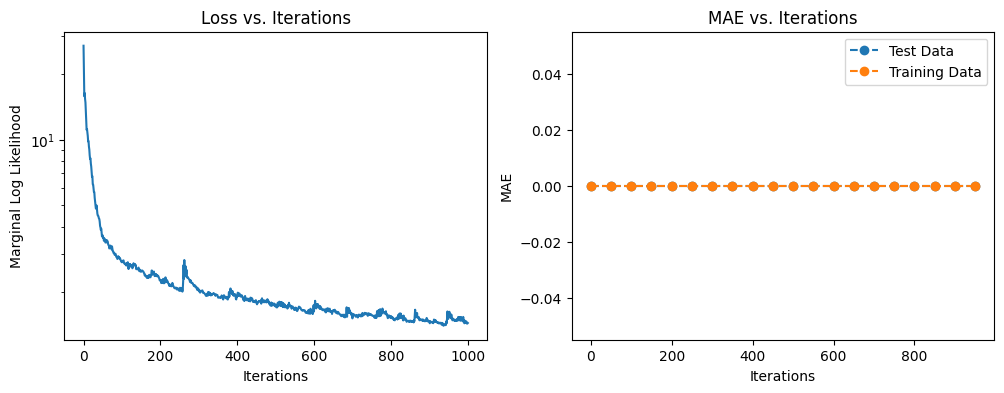

In [8]:
f, ax = plt.subplots(1,2, figsize=(12, 4))
ax[0].semilogy(history_values['mll'][:training_iterations])
ax[0].set_xlabel('Iterations')
ax[0].set_ylabel('Marginal Log Likelihood')
ax[0].title.set_text('Loss vs. Iterations')

ax[1].plot(np.arange(0, training_iterations, interval_checkpt), history_values['test_MSE'][:],'o--', label='Test Data')
ax[1].plot(np.arange(0, training_iterations, interval_checkpt), history_values['train_MSE'][:],'o--', label='Training Data')
ax[1].legend()
ax[1].set_xlabel('Iterations')
ax[1].set_ylabel('MAE')
ax[1].title.set_text('MAE vs. Iterations')

In [ ]:
print(model.covar_module.outputscale.item())
print(model.covar_module.base_kernel.lengthscale)

## Make predictions & obtain MAE

In [ ]:
# fileDir = "/home/hlee981/Documents/GP-Aero/BNN_af_pdist_gen/checkpoints/" + "checkpoint_" + str(iters_checkpt) + "_loss_" + str(history_values['mll'][iters]) + '_trainMAE_' + str(history_values['train_MAE'][iters_checkpt]) + \
#                     '_testMAE_' + str(torch.mean(torch.abs(preds_test.mean - test_y)))
# save_checkpoint(model=model, optimizer=optimizer, history=history_values, fileName=fileDir, iters=iters)

In [26]:
model.eval()
likelihood.eval()

subtest = True
test_num = 0

subtest_af = [test_afu[test_num]]

subtest_x = test_x[test_af.isin(subtest_af).values]
subtest_y = test_y[test_af.isin(subtest_af).values]

if subtest:
    with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
        preds_subtest = model(subtest_x.cuda())
    print(subtest_af)
    print('Subtest MAE: {}'.format(torch.mean(torch.abs(preds_subtest.mean - subtest_y.cuda()))))
else:   
    with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
        preds_test = model(test_x)
    print('Test MAE: {}'.format(torch.mean(torch.abs(preds_test.mean - test_y.cuda()))))


['NACA64A406']
Subtest MAE: 3.241544008255005


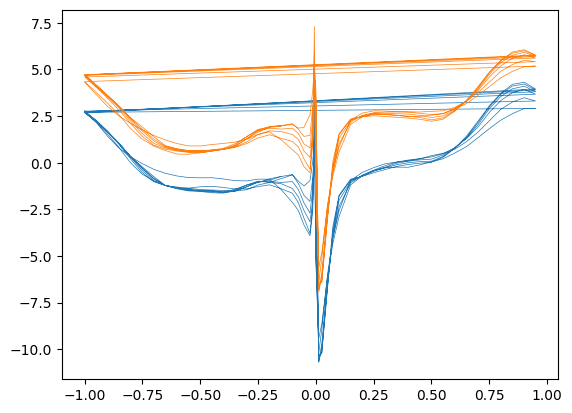

In [27]:
u, l = preds_subtest.confidence_region()
plt.plot(subtest_x[:300, -1].cpu(), u.cpu()[:300], linewidth=0.5)
plt.plot(subtest_x[:300, -1].cpu(), l.cpu()[:300], linewidth=0.5)

In [ ]:
a = alpha_vs_Mach(subtest_x, preds_subtest.mean, subtest_y, titleStr='MAE at various A, M')
b = xc_vs_airfoil(subtest_x, preds_subtest.mean, subtest_y, titleStr='MAE at x/c')

## Results

### Visualize Cp 

0


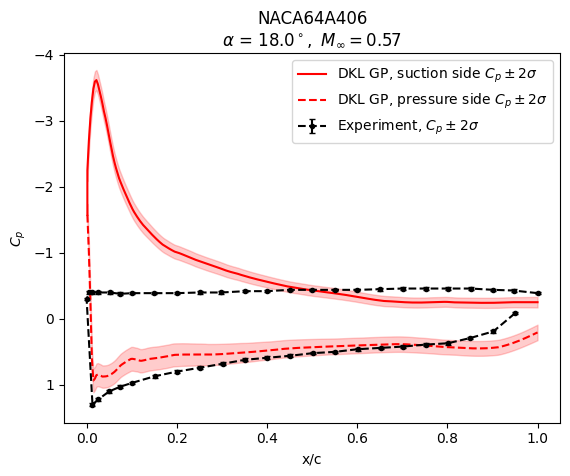

In [51]:
# plotter = [(6.0, test_afu[1], 0.60), (12.2, test_afu[0], 0.31), (0.0, test_afu[1], 0.81), (4.0, test_afu[1], 0.51)]#, (4.0, test_afu[1])]

num_cases_visualize = 1

seeds = np.arange(0, 10)
for i in np.arange(0, 1): # 
    targetAF = test_afu[test_num]
    
    for j in np.arange(0, num_cases_visualize):
        plt.figure()
        temp_ind_af = np.where(test_af.values == targetAF)[0]
        temp_arr = subtest_x#test_x[temp_ind_af, :]

        # Get angle 
        A_list = torch.unique(temp_arr[:, -3])
        if len(A_list) > 1:
            targetA = A_list[torch.randint(low=0, high=len(A_list), size=(1,))][0].cpu()
        else: 
            targetA = A_list[0]
        temp_ind = temp_ind_af[torch.where(temp_arr[:, -3].cpu() == targetA)[0].numpy()]
        temp_arr = temp_arr[torch.where(temp_arr[:, -3].cpu() == targetA)[0].numpy(), :]
        
        # Get Mach 
        M_list = torch.unique(temp_arr[:, -2]).cpu() 
        # print(M_list)
        if len(M_list) > 1:
            targetM = M_list[torch.randint(low=0, high=len(M_list), size=(1,))]
        else: 
            targetM = M_list[0]
        temp_ind = temp_ind[torch.where(temp_arr[:, -2].cpu() == targetM)[0].numpy()]
        temp_arr = temp_arr[torch.where(temp_arr[:, -2].cpu() == targetM)[0].numpy(), :]
    
        
        sample_airfoil_temp = np.tile(temp_arr[0,:-2].cpu(), (600,1))
        # print(sample_airfoil_temp)
        desired_xc = np.linspace(-1, 1, 600).reshape((600,1))
        desired_M = np.ones((600,1))*targetM.detach().numpy()
        sample_airfoil = torch.Tensor(np.hstack((sample_airfoil_temp, desired_M, desired_xc))).cuda()
    
        # Posterior Predictive 
        with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
            sample_airfoil_pred = model(sample_airfoil)
        sample_airfoil_std = np.sqrt(sample_airfoil_pred.variance.cpu())
        sample_airfoil_mean = sample_airfoil_pred.mean.cpu() 
        # print(sample_airfoil_std)
        # Plot experimental data 
        plt.errorbar(np.abs(test_x[temp_ind, -1].cpu()), (test_y[temp_ind].cpu())/y_scale, yerr=2*np.sqrt(noise[temp_ind])/y_scale, fmt='k.--', capsize=2, label='Experiment, $C_p \pm 2\sigma$')
        
        # plt.plot(np.abs(sample_airfoil[:, -1].cpu()), sample_airfoil_pred.sample(sample_shape=1) + torch.mean(y))
        y_mean = 0
        print(y_mean)
        # plt.fill_between(-desired_xc[:300].flatten(), (sample_airfoil_mean[:300]+ y_mean + sample_airfoil_std[:300])/y_scale, 
        #                  (sample_airfoil_mean[:300] + y_mean - sample_airfoil_std[:300])/y_scale, color = 'r', alpha = 0.3)
        # plt.fill_between(desired_xc[300:].flatten(), (sample_airfoil_mean[300:]+ y_mean + sample_airfoil_std[300:])/y_scale,
        #                  (sample_airfoil_mean[300:]+ y_mean - sample_airfoil_std[300:])/y_scale, color = 'r', alpha = 0.3)
        plt.fill_between(-desired_xc[:300].flatten(), (sample_airfoil_mean[:300] + y_mean + 2*sample_airfoil_std[:300])/y_scale, 
                         (sample_airfoil_mean[:300]+ y_mean - 2*sample_airfoil_std[:300])/y_scale, color = 'r', alpha = 0.2)
        plt.fill_between(desired_xc[300:].flatten(), (sample_airfoil_mean[300:] + y_mean + 2*sample_airfoil_std[300:])/y_scale, 
                         (sample_airfoil_mean[300:]+ y_mean - 2*sample_airfoil_std[300:])/y_scale, color = 'r', alpha = 0.2)
        # for j in np.arange(0, 5):
        #     plt.plot(np.abs(sample_airfoil[:, -1].cpu()), newDist.sample()+ torch.mean(y), alpha = 0.2, color = 'r')
        plt.plot(np.abs(sample_airfoil[:300+1, -1].cpu()), (sample_airfoil_mean + y_mean)[:300+1]/y_scale,'r', label='DKL GP, suction side $C_p \pm 2\sigma$')
        plt.plot(np.abs(sample_airfoil[300:, -1].cpu()), (sample_airfoil_mean + y_mean)[300:]/y_scale,'r--', label='DKL GP, pressure side $C_p \pm 2\sigma$')
        plt.gca().invert_yaxis()
        plt.xlabel('x/c')
        plt.ylabel('$C_p$')
        plt.legend()
        plt.title(targetAF +'\n' + r'$\alpha$ = ' + str(np.round(np.rad2deg(targetA.detach().numpy()),2)) + r'$^\circ,$' + r' $M_\infty = $' + str(targetM.detach().numpy().flatten()[0]))


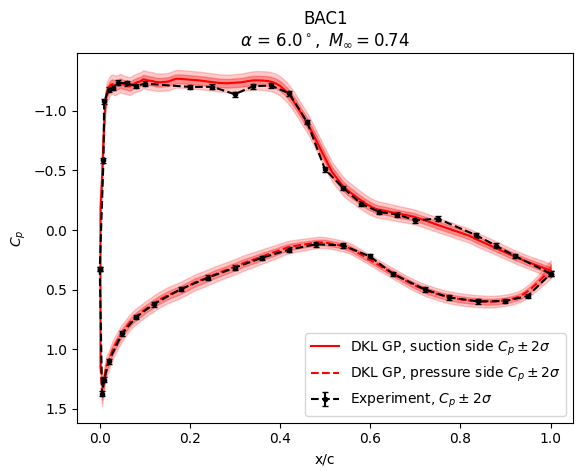

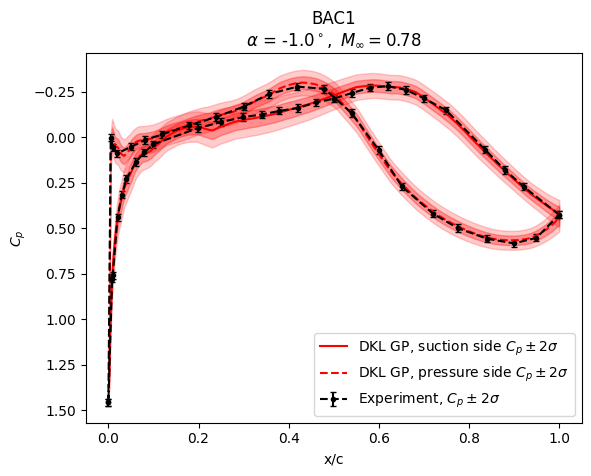

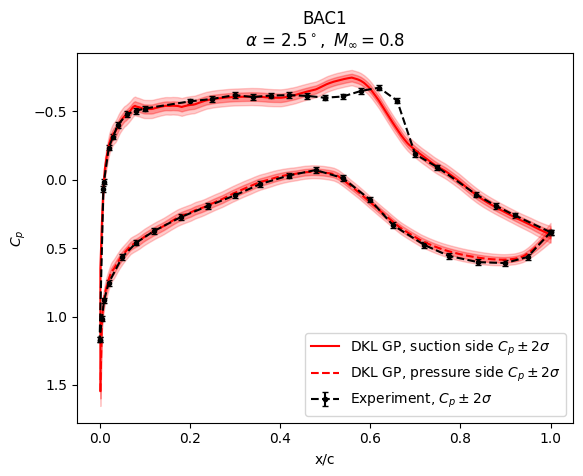

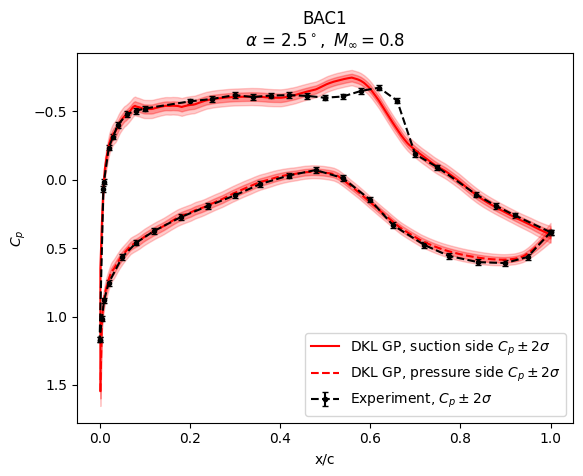

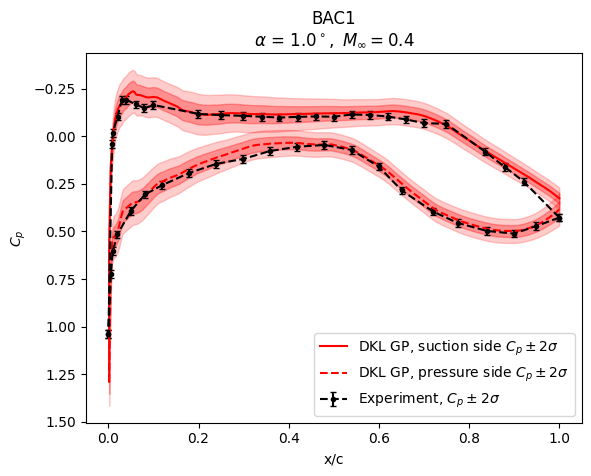

In [25]:
num_cases_visualize = 5

for i in np.arange(0, 1): # len(test_afu)
    targetAF = train_afu[0]
    
    for j in np.arange(0, num_cases_visualize):
        plt.figure()
        temp_ind_af = np.where(train_af.values == targetAF)[0]
        temp_arr = train_x[temp_ind_af, :]

        # Get angle 
        A_list = torch.unique(temp_arr[:, -3])
        targetA = A_list[torch.randint(low=0, high=len(A_list)-1, size=(1,))][0].cpu()
        temp_ind = temp_ind_af[torch.where(temp_arr[:, -3].cpu() == targetA)[0].numpy()]
        temp_arr = temp_arr[torch.where(temp_arr[:, -3].cpu() == targetA)[0].numpy(), :]
        
        # Get Mach 
        M_list = torch.unique(temp_arr[:, -2]).cpu() 
        if len(M_list) > 1:
            targetM = M_list[torch.randint(low=0, high=len(M_list)-1, size=(1,))]
        else:
            targetM = M_list[0]
    
        temp_ind = temp_ind[torch.where(temp_arr[:, -2].cpu() == targetM)[0].numpy()]
        temp_arr = temp_arr[torch.where(temp_arr[:, -2].cpu() == targetM)[0].numpy(), :]
    
        num_pts = 600
        half_pt = int(num_pts/2)
        sample_airfoil_temp = np.tile(temp_arr[0,:-2].cpu(), (num_pts,1))
        desired_xc = np.linspace(-1, 1, num_pts).reshape((num_pts,1))
        desired_M = np.ones((num_pts,1))*targetM.detach().numpy()
        sample_airfoil = torch.Tensor(np.hstack((sample_airfoil_temp, desired_M, desired_xc))).cuda()

        # Posterior Predictive 
        with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
            sample_airfoil_pred = model(sample_airfoil)
        sample_airfoil_std = np.sqrt(sample_airfoil_pred.variance.cpu())
        sample_airfoil_mean = sample_airfoil_pred.mean.cpu() 
        
        # Plot experimental data 
        plt.errorbar(np.abs(train_x[temp_ind, -1].cpu()), (train_y[temp_ind].cpu() + torch.mean(y))/y_scale, yerr=2*np.sqrt(noise[temp_ind])/y_scale, fmt='k.--', capsize=2, label='Experiment, $C_p \pm 2\sigma$')
        # print(torch.mean(y))
        # plt.plot(np.abs(sample_airfoil[:, -1].cpu()), sample_airfoil_pred.sample(sample_shape=1) + torch.mean(y))
        plt.fill_between(-desired_xc[:half_pt].flatten(), (sample_airfoil_mean[:half_pt]+ torch.mean(y) + sample_airfoil_std[:half_pt])/y_scale, 
                         (sample_airfoil_mean[:half_pt]+ torch.mean(y) - sample_airfoil_std[:half_pt])/y_scale, color = 'r', alpha = 0.3)
        plt.fill_between(desired_xc[half_pt:].flatten(), (sample_airfoil_mean[half_pt:]+ torch.mean(y) + sample_airfoil_std[half_pt:])/y_scale,
                         (sample_airfoil_mean[half_pt:]+ torch.mean(y) - sample_airfoil_std[half_pt:])/y_scale, color = 'r', alpha = 0.3)
        plt.fill_between(-desired_xc[:half_pt].flatten(), (sample_airfoil_mean[:half_pt]+ torch.mean(y) + 2*sample_airfoil_std[:half_pt])/y_scale, 
                         (sample_airfoil_mean[:half_pt]+ torch.mean(y) - 2*sample_airfoil_std[:half_pt])/y_scale, color = 'r', alpha = 0.2)
        plt.fill_between(desired_xc[half_pt:].flatten(), (sample_airfoil_mean[half_pt:]+ torch.mean(y) + 2*sample_airfoil_std[half_pt:])/y_scale, 
                         (sample_airfoil_mean[half_pt:]+ torch.mean(y) - 2*sample_airfoil_std[half_pt:])/y_scale, color = 'r', alpha = 0.2)
        # for j in np.arange(0, 5):
        #     plt.plot(np.abs(sample_airfoil[:, -1].cpu()), newDist.sample()+ torch.mean(y), alpha = 0.2, color = 'r')
        plt.plot(np.abs(sample_airfoil[:half_pt+1, -1].cpu()), (sample_airfoil_mean + torch.mean(y))[:half_pt+1]/y_scale,'r', label='DKL GP, suction side $C_p \pm 2\sigma$')
        plt.plot(np.abs(sample_airfoil[half_pt:, -1].cpu()), (sample_airfoil_mean + torch.mean(y))[half_pt:]/y_scale,'r--', label='DKL GP, pressure side $C_p \pm 2\sigma$')
        plt.gca().invert_yaxis()
        plt.xlabel('x/c')
        plt.ylabel('$C_p$')
        plt.legend()
        plt.title(targetAF +'\n' + r'$\alpha$ = ' + str(np.round(np.rad2deg(targetA.detach().numpy()), 2)) + r'$^\circ,$' + r' $M_\infty = $' + str(targetM.detach().numpy().flatten()[0]))

## Latent variables - dont use this for now 

In [ ]:
# Latent variable plotter 1 - Latent variables vs each other 
extracted_values = model.feature_extractor(train_x)
extracted_values = model.scale_to_bounds(extracted_values)
extracted_values = extracted_values.cpu().detach().numpy()

N_var = nn_dims[3]
f, ax = plt.subplots(N_var, N_var-1, figsize = (18, 18))
for i in np.arange(0, N_var):
    for j in np.arange(0, i):
        for jj in np.arange(0, train_afu.shape[0]):
            plot_ind = np.argwhere(train_af.values == train_afu[jj])
            ax[i,j].scatter(extracted_values[plot_ind, i], extracted_values[plot_ind, j], marker='.',s=8)
        if j == 0:
            ax[i,j].set_ylabel('Variable ' + str(i+1), rotation=0, fontsize=12, labelpad = 30)
        if i == N_var-1:
            ax[i,j].set_xlabel('Variable ' + str(j+1), rotation=0, fontsize=12)
        
    for k in np.arange(i, N_var-1):
        f.delaxes(ax[i,k])

In [ ]:
# Latent variable plotter 1 - Latent variables vs each other 
extracted_values = model.feature_extractor(train_x)
extracted_values = model.scale_to_bounds(extracted_values)
extracted_values = extracted_values.cpu().detach().numpy()

N_var = nn_dims[3]
f, ax = plt.subplots(N_var, N_var-1, figsize = (18, 18))

# plt.figure()
# plt.scatter(extracted_values[:, 0], extracted_values[:, 1], c=train_y.cpu(), marker='.', s=8)

for i in np.arange(0, N_var):
    for j in np.arange(0, i):
        ff = ax[i,j].scatter(extracted_values[:, i], extracted_values[:, j], c=train_y.cpu(), marker='.', s=8)
        
        if j == 0:
            ax[i,j].set_ylabel('Variable ' + str(i+1), rotation=0, fontsize=12, labelpad = 30)
        if i == N_var-1:
            ax[i,j].set_xlabel('Variable ' + str(j+1), rotation=0, fontsize=12)
        
    for k in np.arange(i, N_var-1):
        f.delaxes(ax[i,k])
        
cbar = plt.colorbar(ff)



In [ ]:
extracted_values = model.feature_extractor(train_x)
extracted_values = model.scale_to_bounds(extracted_values)
extracted_values = extracted_values.cpu().detach().numpy()

N_var = nn_dims[3]
f, ax = plt.subplots(N_var, N_var-1, figsize = (18, 18))
for i in np.arange(0, N_var):
    for j in np.arange(0, i):
        ax[i,j].scatter(extracted_values[:, i], extracted_values[:, j], c=preds_train.mean.cpu(), marker='.', s=8)
        
        if j == 0:
            ax[i,j].set_ylabel('Variable ' + str(i+1), rotation=0, fontsize=12, labelpad = 30)
        if i == N_var-1:
            ax[i,j].set_xlabel('Variable ' + str(j+1), rotation=0, fontsize=12)
        
    for k in np.arange(i, N_var-1):
        f.delaxes(ax[i,k])

## Cl Cd calculation 

In [ ]:

manual_Cl = -np.trapz(y=(sample_airfoil_pred.mean.cpu()+torch.mean(y))[:150], x=desired_xc.flatten()[:150]) + np.trapz(y=(sample_airfoil_pred.mean.cpu()+torch.mean(y))[150:], x=desired_xc.flatten()[150:])
print(np.trapz(y=(sample_airfoil_pred.mean.cpu())[:150]+torch.mean(y), x=desired_xc.flatten()[:150]) + np.trapz(y=(sample_airfoil_pred.mean.cpu())[150:]+torch.mean(y), x=desired_xc.flatten()[150:]))
# torch.linalg.inv(temp_Kxx) @ train_y.cpu()
# print(model.covar_module(train_x))

print(sample_airfoil[0,-2])
def lazy_Cl_Cd_Cm(x, cp, a):
    N = np.trapz(cp[:150], x=np.abs(x.flatten())[:150]) + np.trapz(cp[150:], x=x.flatten()[150:])
    Cl = N * np.cos(np.deg2rad(a))
    Cd = N * np.sin(np.deg2rad(a))
    Cm = np.trapz((np.abs(x.flatten())[:150]-0.25) * cp[:150], x=np.abs(x.flatten())[:150]) + np.trapz((x.flatten()[150:]-0.25) * cp[150:], x=x.flatten()[150:]) # <- double check
    return Cl, Cd, Cm  

def GP_Cl_Cd_Cm(model, train_x, test_data):
    model = model.cpu()
    train_x = train_x.cpu()
    test_data = test_data.cpu()
    
    projected_xtrain = model.feature_extractor(train_x)
    projected_xtrain = model.scale_to_bounds(projected_xtrain)
    projected_xtest = model.feature_extractor(test_data)
    projected_xtest = model.scale_to_bounds(projected_xtest)
    jitter = 1e-5 * torch.eye(train_x.shape[0])
    Kxx = (model.covar_module(projected_xtrain).evaluate().cpu() + train_noise * torch.eye(train_x.shape[0]) + jitter).detach().numpy()
    Kxs = model.covar_module(projected_xtrain, projected_xtest).evaluate().cpu().detach().numpy()

    KxsT = Kxs.T
    temp_ind = np.argwhere(np.array(desired_xc).flatten() < 0.0)
    KxsT[temp_ind, :] *= -1
    i_Kxs = np.trapz(y=KxsT, x=np.array(desired_xc).flatten(), axis=0).reshape((-1,1)).T
    N = i_Kxs @ np.linalg.inv(Kxx) @ train_y.cpu().numpy()
    a = test_data[0, -2].numpy()
    print(N)
    Cl = N * np.cos(np.deg2rad(a))
    Cd = N * np.sin(np.deg2rad(a))
    # Cm = np.trapz((np.abs(x.flatten())[:150]-0.25) * cp[:150], x=np.abs(x.flatten())[:150]) + np.trapz((x.flatten()[150:]-0.25) * cp[150:], x=x.flatten()[150:]) # <- double check
    return Cl, Cd  

lazy_Cl_Cd_Cm(desired_xc.flatten(), (sample_airfoil_pred.mean.cpu()+torch.mean(y)).detach().numpy(), a = 9.1)
GP_Cl_Cd_Cm(model, train_x, sample_airfoil)

DEBUG

In [ ]:
ref_x_U = data_raw[data_raw.columns[:num_xc//2]].values[0]#np.flip(1-np.cos(np.linspace(0,np.pi/2,30)))
ref_x_L = data_raw[data_raw.columns[num_xc//2:num_xc]].values[0]#1-np.cos(np.linspace(0,np.pi/2,30))
ref_x = np.hstack((ref_x_U, ref_x_L))

print(np.unique(af.values))

In [ ]:
# af = ['NACA0012']
import copy 
temp_x = copy.deepcopy(test_x.cpu()).detach().numpy()
# plt.plot(ref_x, temp_x[0,:60],'.-')
for i in range(0, len(test_afu)):
    temp_ind_af = np.where(test_af.values == test_afu[i])
    temp_arr = temp_x[temp_ind_af[0][0], :]
    
    plt.figure(figsize=(12,3))
    plt.plot(ref_x, temp_arr[:num_xc] ,'.-')
    plt.title(test_afu[i])
    plt.ylim([-.1, .1])

In [ ]:
plt.plot(train_noise)